# Orbit Diagram

Plot the orbits of comet 46P/Wirtanen, Earth, and Jupiter, and the position of the comet during observations of interest.

First, import needed packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time
from sbpy.data import Ephem, Orbit
%matplotlib notebook

## Orbits

Define the dates of interest and retrieve orbits for Earth, Jupiter, and the comet in 2018.  For the comet, we'll also want the perihelion date in 2008.

In [2]:
obs_dates = {
    'spitzer': Time(['2007-12-08', '2008-01-17', '2008-04-24', 
                     '2008-05-24', '2008-07-02']),
    'bass': Time('2018-12-10')
}

epochs = (obs_dates['spitzer'].jd.mean(), obs_dates['bass'])
comet = Orbit.from_horizons('46P', 'designation', epochs=epochs,
                            closest_apparition=True)

epochs = obs_dates['bass']
planets = Orbit.from_horizons((399, 599), 'majorbody', epochs=epochs)

## Inspect the results

In [3]:
print(comet, planets)

<QTable masked=True length=2>
 targetname  datetime_jd ...         P         timescale
                  d      ...         d                  
   str12       float64   ...      float64         str3  
------------ ----------- ... ----------------- ---------
46P/Wirtanen   2454553.1 ... 1986.996495396485       TDB
46P/Wirtanen   2458462.5 ... 1986.326800236656       TDB <QTable masked=True length=2>
  targetname  datetime_jd ...         P         timescale
                   d      ...         d                  
    str13       float64   ...      float64         str3  
------------- ----------- ... ----------------- ---------
  Earth (399)   2458462.5 ... 365.6866472053913       TDB
Jupiter (599)   2458462.5 ... 4332.251816544361       TDB


In [4]:
print(comet.field_names)

<TableColumns names=('targetname','datetime_jd','datetime_str','M1','e','k1','q','incl','Omega','w','Tp_jd','n','M','nu','a','Q','P','timescale')>


## Define some plotting functions

One to plot the full orbit, the other for positions of the object at particular dates:

In [5]:
def plot_orbit(ax, orb, **plot_kwargs):
    """Orthographic projection onto the xy plane.
    
    2-body propagation of orbital elements, neglecting non-grav forces.
    
    """
    epochs = orb['datetime_jd'] + np.linspace(-1, 1, 1000) * orb['P'] / 2
    eph = Ephem.from_oo(orb, epochs=epochs, dynmodel='2')
    ax.plot(eph['x'].value, eph['y'].value, **plot_kwargs)
    
def plot_object(ax, orb, epochs, **plot_kwargs):
    """Same as plot_orbit, but for single points."""
    eph = Ephem.from_oo(orb, epochs=epochs, dynmodel='2')
    ax.scatter(eph['x'].value, eph['y'].value, **plot_kwargs)

## Plot

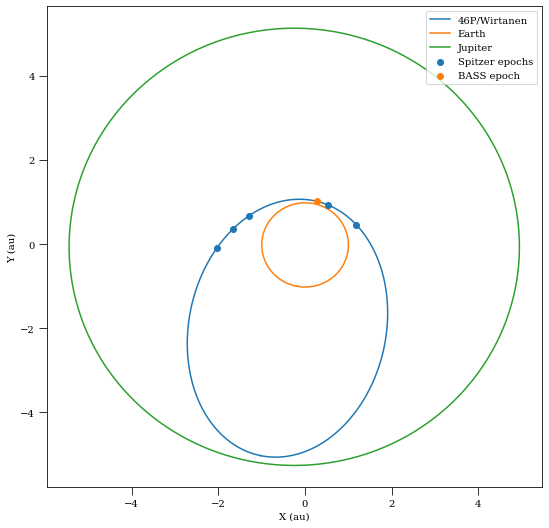

In [6]:
fig = plt.figure(1, (8, 8))
fig.clear()
ax = fig.gca()

# H and G required for openorb's propagation
comet['H'] = 0
comet['G'] = 0.15
planets['H'] = 0
planets['G'] = 0.15

# orbits
for label, orb in zip(('46P/Wirtanen', 'Earth', 'Jupiter'),
                      (comet[1], planets[0], planets[1])):
    plot_orbit(ax, orb, label=label)

Tp08 = Time(comet[0]['Tp_jd'], format='jd', scale='tt')
Tp19 = Time(comet[1]['Tp_jd'], format='jd', scale='tt')
   
# comet in 2008 (approximated with 2019 elements)
TmTp = obs_dates['spitzer'] - Tp08
epochs = (TmTp + Tp19).jd  # Julian Dates as a work around Issue #206
plot_object(ax, comet[1], epochs, label='Spitzer epochs', zorder=99)

# comet in 2019
plot_object(ax, comet[1], obs_dates['bass'], label='BASS epoch', zorder=99)

plt.setp(ax, xlabel='X (au)', ylabel='Y (au)')
plt.legend()
plt.show()